In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!curl https://course-v3.fast.ai/setup/colab | bash

from fastai import *
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   287  100   287    0     0    309      0 --:--:-- --:--:-- --:--:--   308
bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">'
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


At this point the images are stored on my personal Drive, so the code above mounted the drive. 
Check that we can access the images:

In [4]:
path = Path('/content/drive/My Drive/HackathonProject/training_set') 
os.listdir(path)


['violent',
 'peaceful',
 'models',
 'Hackathon feedback notes.gdoc',
 'export.pkl']

Let's build the data from the folder with the images (organized in two separate folders, one for each category: peaceful and violent). Split into 75% training set and 25% validation set.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.25, ds_tfms=get_transforms(), size=200, num_workers=0).normalize(imagenet_stats)

In [5]:
print(data.classes)

['peaceful', 'violent']


Print a few images to check that they look good and all data is there, also that the labelling makes sense:

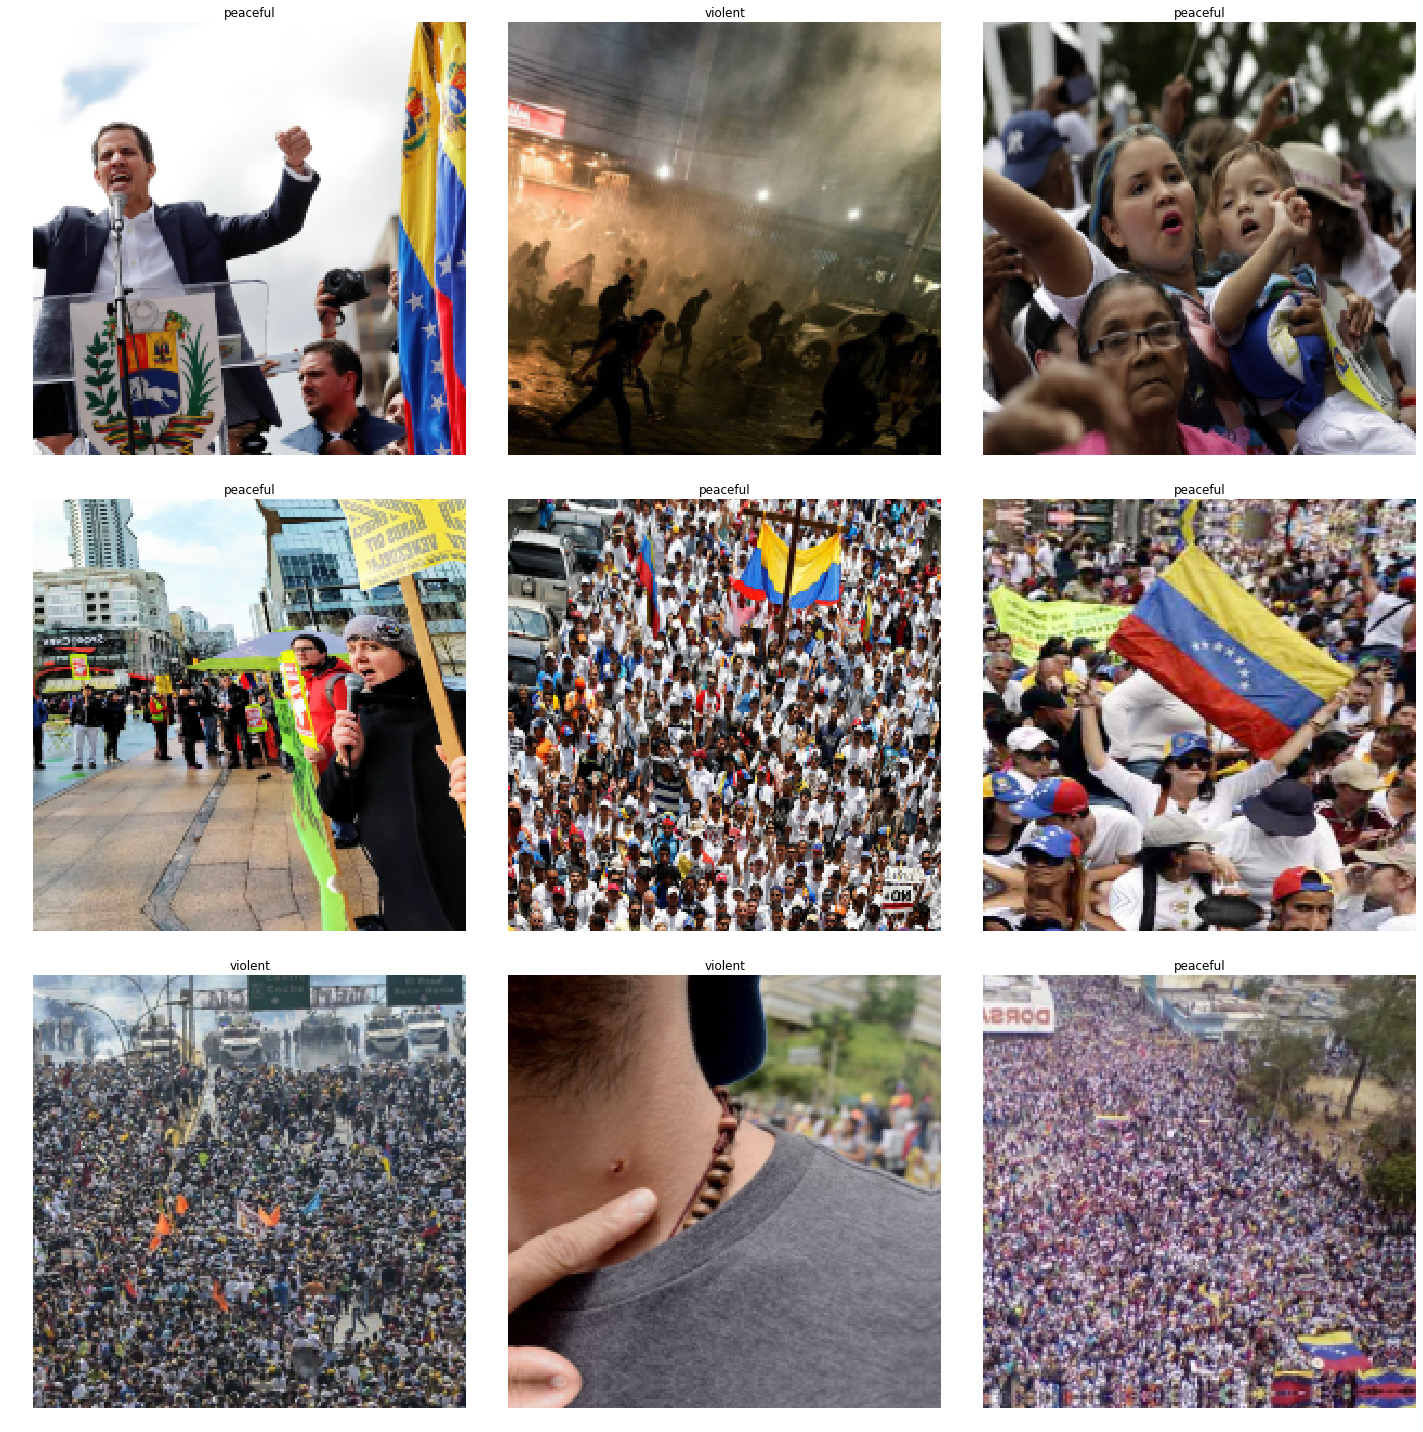

In [0]:
data.show_batch(rows=3, figsize=(20,20))

In [0]:
print(data.classes)
len(data.classes),data.c

['peaceful', 'violent']


(2, 2)

Check how many images there are for training and how many for testing:

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['peaceful', 'violent'], 2, 1134, 378)

Train a model with the resnet34 (least resource-intensive) network (meaning 34 layers):

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
learn.model

Fit over 8 times to check for consistency 

In [0]:
learn.fit_one_cycle(8)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:

interp.plot_top_losses(9, figsize=(12,12))



Confusion matrix shows a pretty good performance.

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)


Check the images that got most confused - they seem to be really hard even for a human observer

In [0]:
interp.most_confused(min_val=3) 

Save the model so we can play around with the learning rate for each layer - parameter tuning:

In [0]:
learn.save('peace_violent34-stage1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

In [0]:
learn.load('peace_violent34-stage1');

In [0]:
learn.lr_find()


In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

In [0]:
learn.save('peace_violent34-stage2')

We got good results with the 34 layers, let's see whether 50 layers will improve performance in a meaningful way:

In [0]:
learn50 = cnn_learner(data, models.resnet50, metrics=accuracy)

In [7]:
learn50.fit_one_cycle(8)

Accuracy is about 8-10% higher with resnet50, this is really good for our image set:

In [8]:
interp50 = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp50.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
#learn50.load('peace_violent50-stage2');

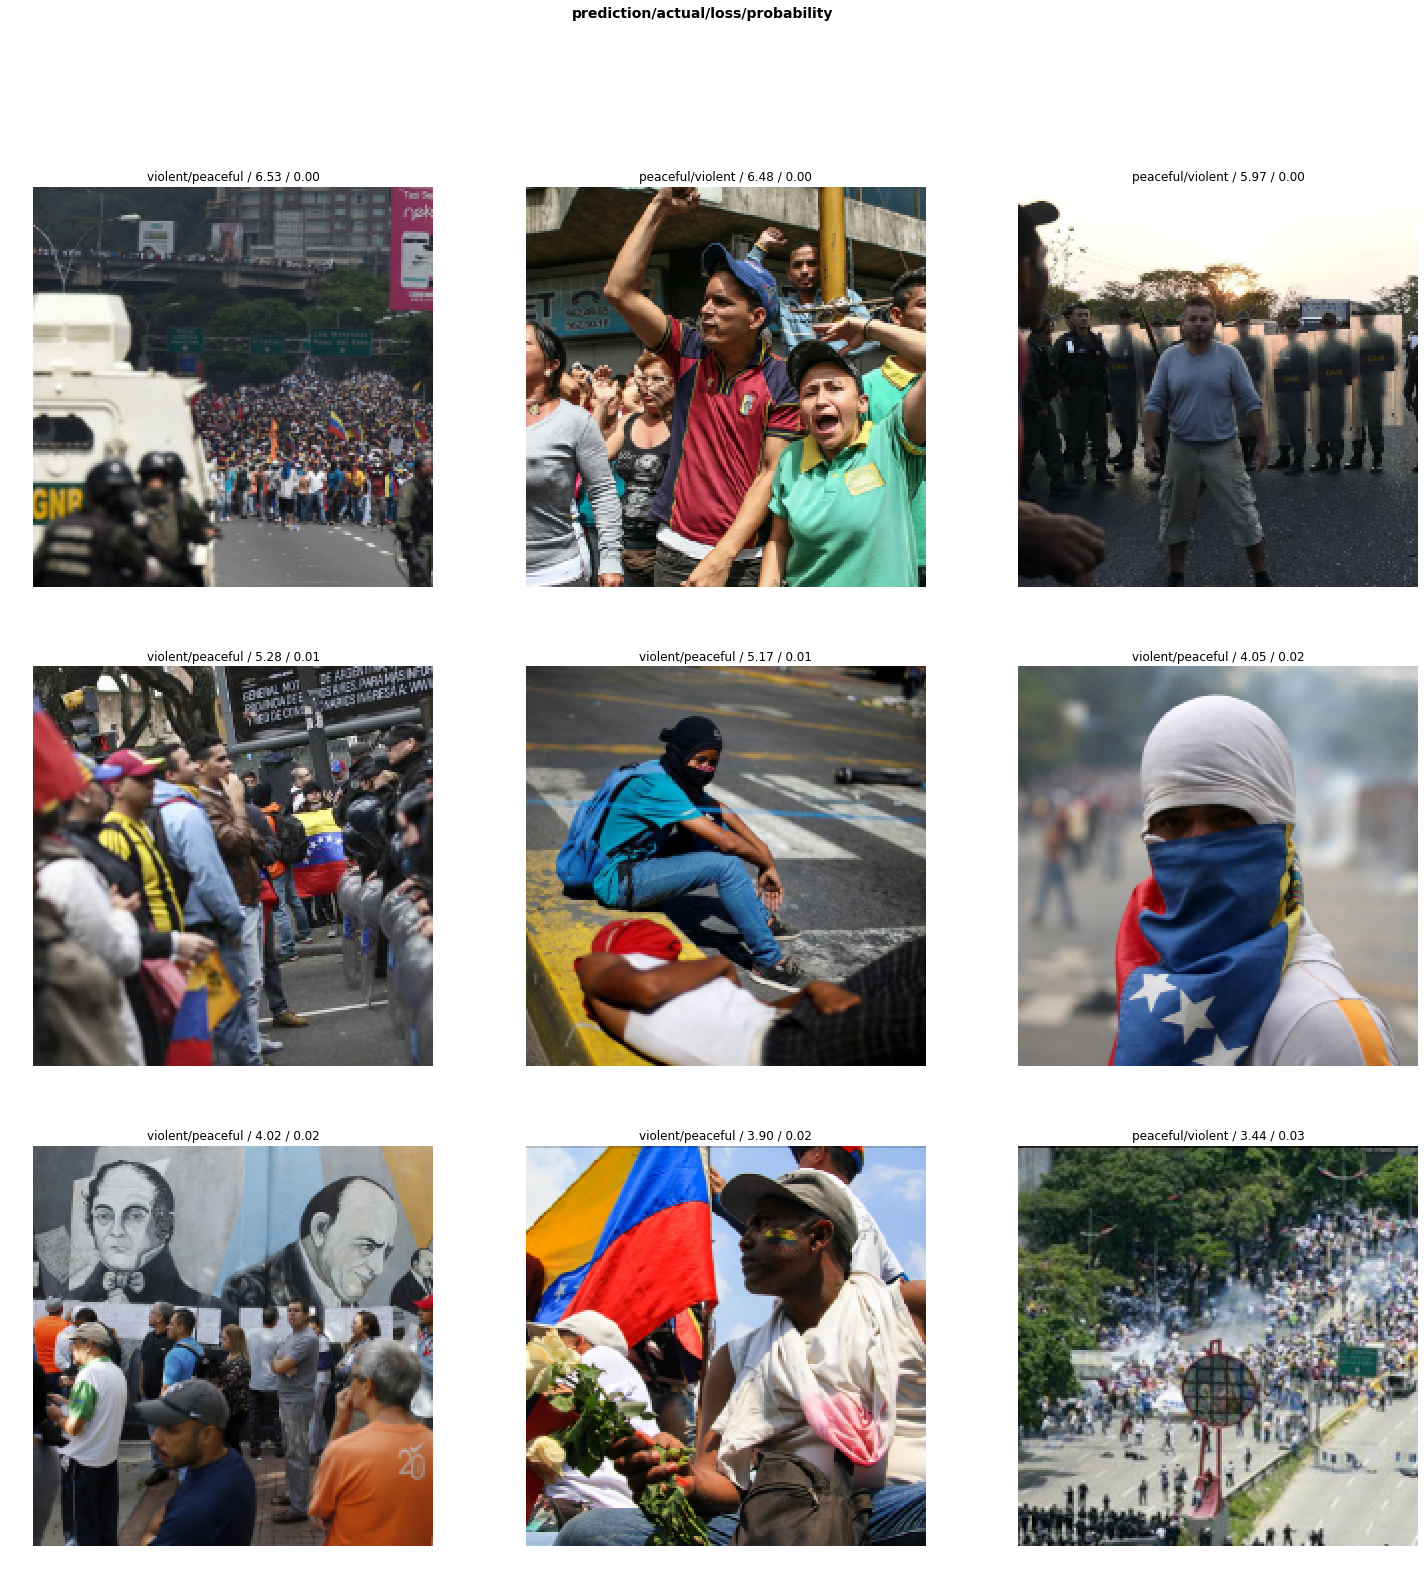

In [0]:
interp50.plot_top_losses(9, figsize=(25,25), heatmap=False)

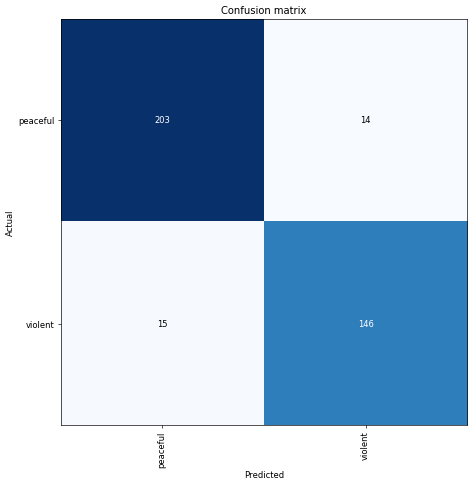

In [9]:
interp50.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [10]:
interp50.most_confused(min_val=1) # actual, predicted, number of occurrences

[('violent', 'peaceful', 15), ('peaceful', 'violent', 14)]

In [0]:
learn50.save('peace_violent50-stage1')

Parameter tuning for resnet50 model:

In [0]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


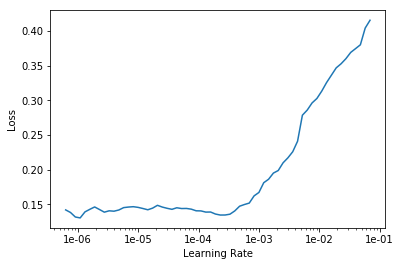

In [13]:
learn50.lr_find()
learn50.recorder.plot()

The loss increases sharply for learning rates above 0.001, so let's curb it before that:

In [14]:

learn50.fit_one_cycle(4, max_lr=slice(1e-06,1e-04))

There is an improvement, but it's really small. The accuracy, however, is very good as it is. 

In [15]:
interp50 = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp50.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Plot the top losses with a feature importance heatmap superimposed to see what parts of the images were most informative in a bad decision:

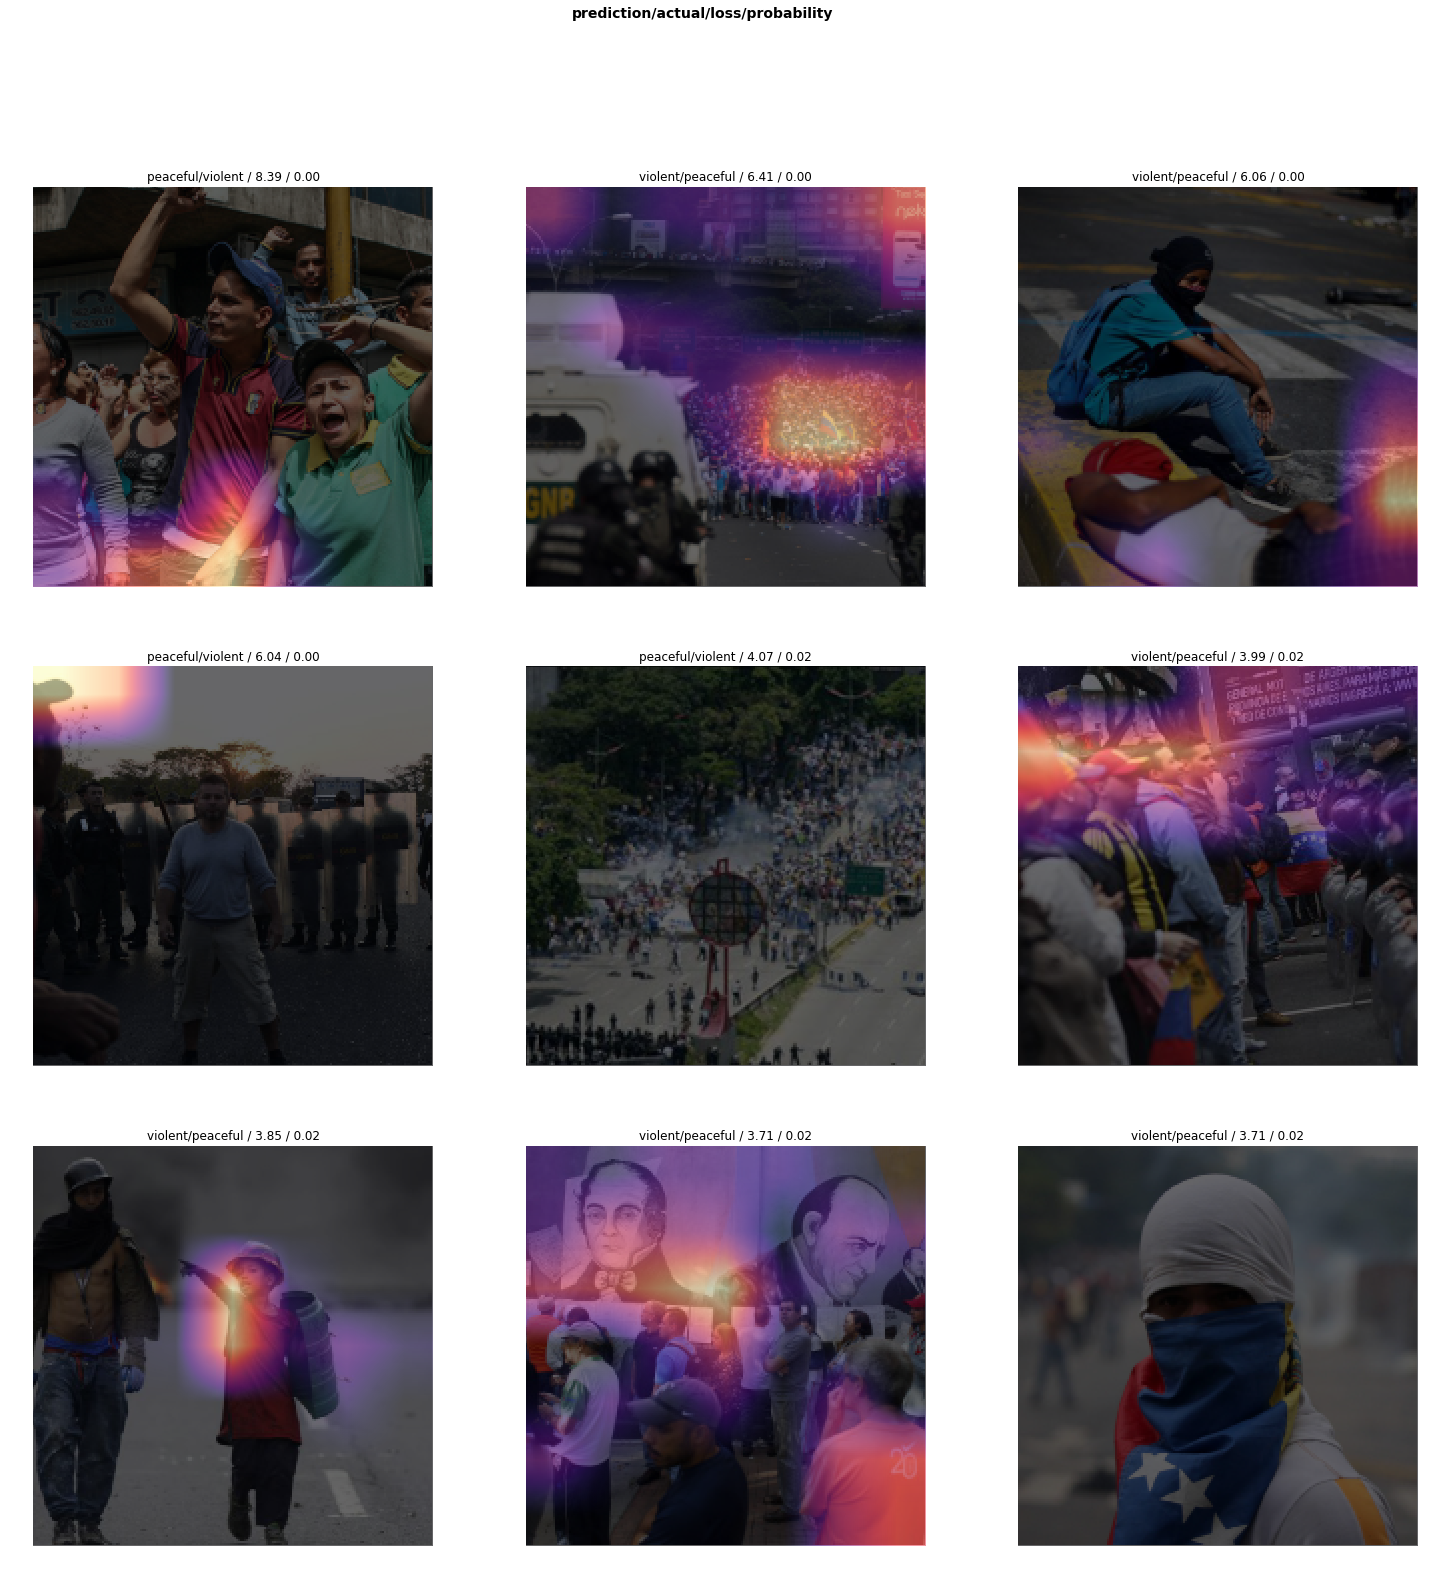

In [0]:
interp50.plot_top_losses(9, figsize=(25,25))

In [16]:
interp50.most_confused(min_val=1) # actual, predicted, number of occurrences

[('violent', 'peaceful', 14), ('peaceful', 'violent', 13)]

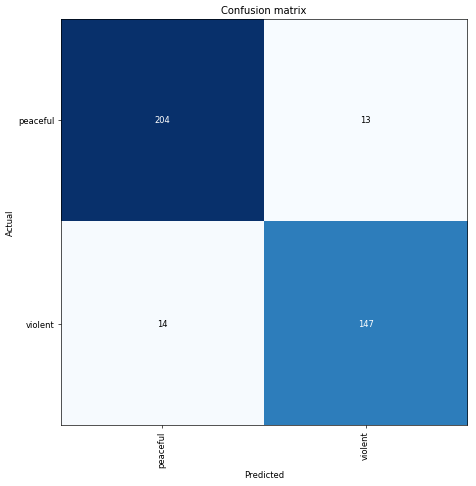

In [17]:
interp50.plot_confusion_matrix(figsize=(8,8), dpi=60)

THe confusion matrix looks very good.

In [0]:
learn50.save('peace_violent50-stage2')

Save the trained model for predictions:

In [0]:
learn50.export()

In [0]:
path = Path('/content/drive/My Drive/HackathonProject/training_set/')
path_test = Path('/content/drive/My Drive/HackathonProject/Test/')
learn = load_learner(path)

In [14]:
os.listdir(path_test)


['image1.jpg',
 'image5.jpg',
 'image4.jpg',
 '433390036760158208_BgO18S3IgAEMR6X.jpg',
 '433390470824464384_BgO2Vj7IMAA_7HY.jpg',
 '433390436166955008_BgO2TixIQAAstb8.jpg',
 '433390763385581568_BgO2ml4IYAAGOyA.jpg',
 '433391004805120000_BgO2lipIgAE_AaA.jpg',
 '433390869719552000_BgONodvCcAAGbza.jpg',
 '433391072694120448_BgO24mkCMAAPIAf.jpg',
 '433391264935845888_BgO3DyuCIAERwTM.jpg',
 '433391624312594432_BgO3Ys8IQAAuIO2.jpg',
 '433391372637569024_BgO3KDgIMAAO-Wn.jpg',
 '433391825047408640_BgOicTYCcAA3-fe.jpg',
 '433391855703584768_BgO3SprIMAAfpd3.jpg',
 'image3.jpg',
 'image2.jpg',
 'image7.jpg',
 'image6.jpg']